In [2]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from scipy.sparse import linalg as spla
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
from dedalus.extras import plot_tools
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__) 
from matplotlib.animation import FFMpegWriter

STRNAME = "sphere110"
#add path to data folder
input_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/data"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/garbage"
first_frame = 1
last_frame = len(glob.glob1('%s/%s/' %(input_folder, STRNAME),"*.npz"))
#last_frame = 1000
dpi = 256
Omega = 500

# Setup output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

t_arr = np.zeros(last_frame)
print('Total time stamps = %i' %(last_frame))


Total time stamps = 5000


In [3]:
with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, 1)) as file:
    phi = file['phi']
    theta = file['theta']

vph = np.zeros((last_frame, phi.shape[0], theta.shape[0]))
om = np.zeros_like(vph)
    
for ind in range(first_frame, last_frame + 1, 1):
    if ind%100==0: print(ind)
    with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
        vph[ind-1, :, :] = file['v_ph']
        om[ind-1, :, :] = file['om']
        t_arr[ind-1] = file['t'][0]

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [4]:
#define function that returns the neutral ell's for a given R/Lambda and kappa
def get_l(Lmid, kappa):
    
    gamma0, gamma2, gamma4 = get_gammas(Lmid, kappa)
    delta_p = (0.5/gamma4)*(-gamma2+np.sqrt(gamma2**2-4*gamma0*gamma4))
    delta_m = (0.5/gamma4)*(-gamma2-np.sqrt(gamma2**2-4*gamma0*gamma4))
    
    l_p = 0.5*(-1+np.sqrt(17+4*delta_p))
    l_m = 0.5*(-1+np.sqrt(17+4*delta_m))
        
    return l_p, l_m

def get_gammas(Lmid, kappa):
    
    a = 0.25*(Lmid**2*kappa**2 - 0.5*(2*np.pi*Lmid+1)**2)**2 + 17*17/16 - (34/16)*(2*np.pi*Lmid+1)**2
    b = (17/4 - 0.25*(2*np.pi*Lmid+1)**2)**2
    c = 1/(17/4 - 0.25*(2*np.pi*Lmid + 1)**2 - 2)
    gamma0 = a*c/(a-b)
    gamma2 = -2*np.sqrt(b)*c/(a-b)
    gamma4 = c/(a-b)
    
    return [gamma0, gamma2, gamma4]



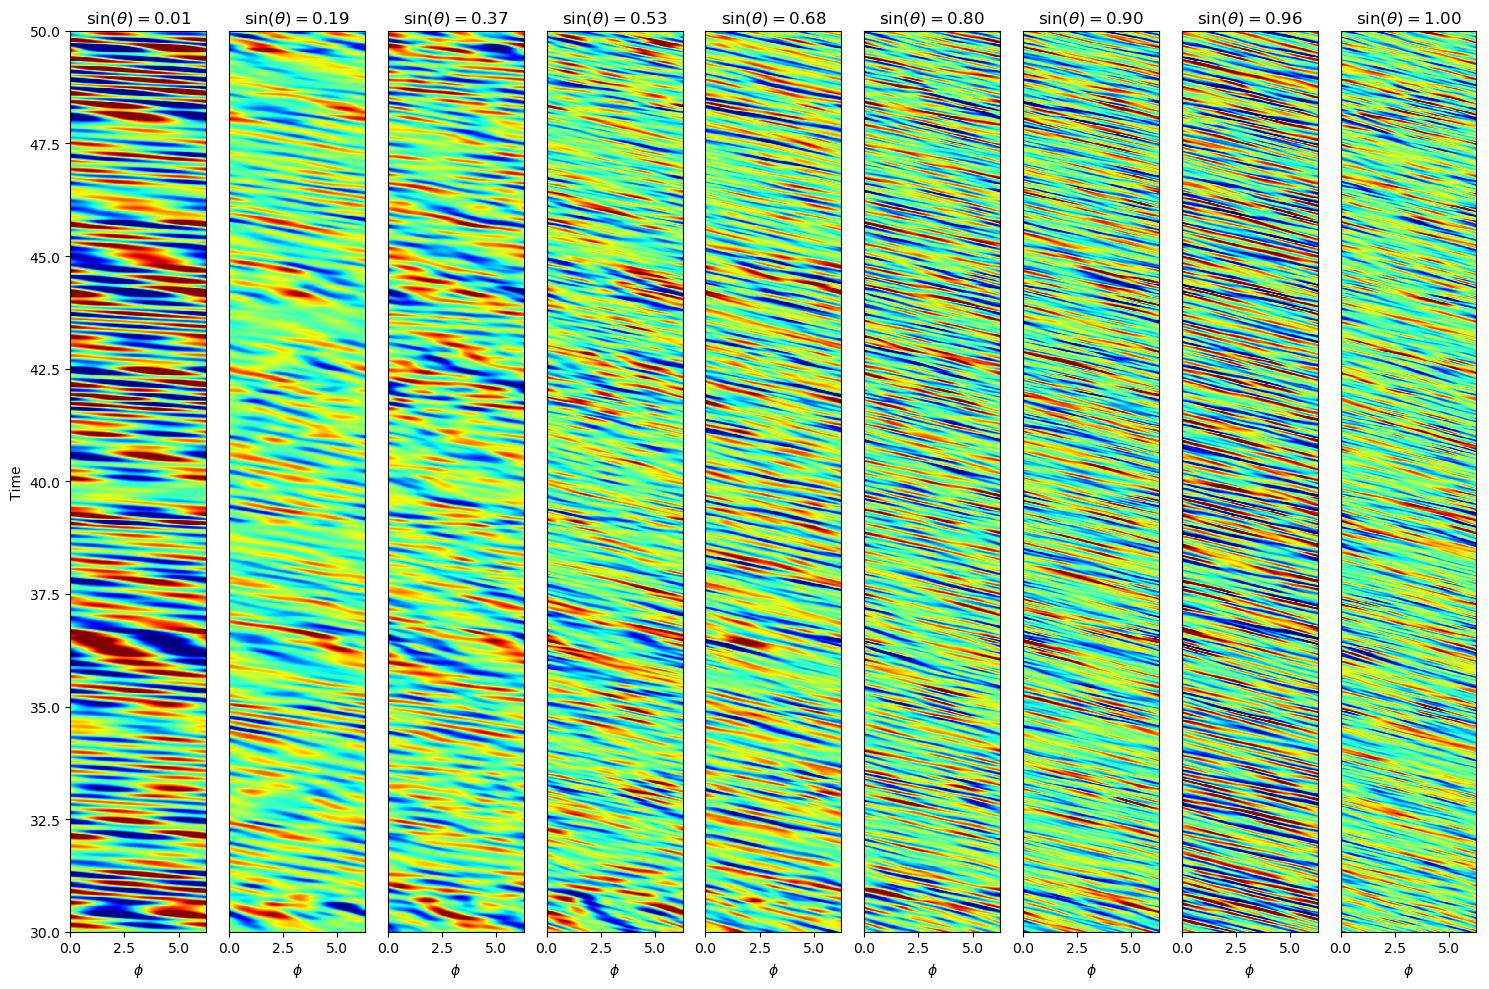

In [57]:
th_inds = np.arange(255, 128, -15, dtype=int)

plt.figure(figsize=(15, 10), dpi=100)

count = 1
for i in th_inds:
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi, t_arr, vph[:,:,i] - np.mean(vph[:,:,i], axis=1, keepdims=True), cmap='jet' \
                   , vmin=-5, vmax=5)
    plt.ylim([30,50])
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Time')
    plt.title(r'$\sin(\theta) = %0.2f$' %(np.sin(theta[i])))
    plt.xlabel(r'$\phi$')

    count += 1

plt.tight_layout()

plt.savefig('../plots/rossby_colorplot.png')
plt.show()

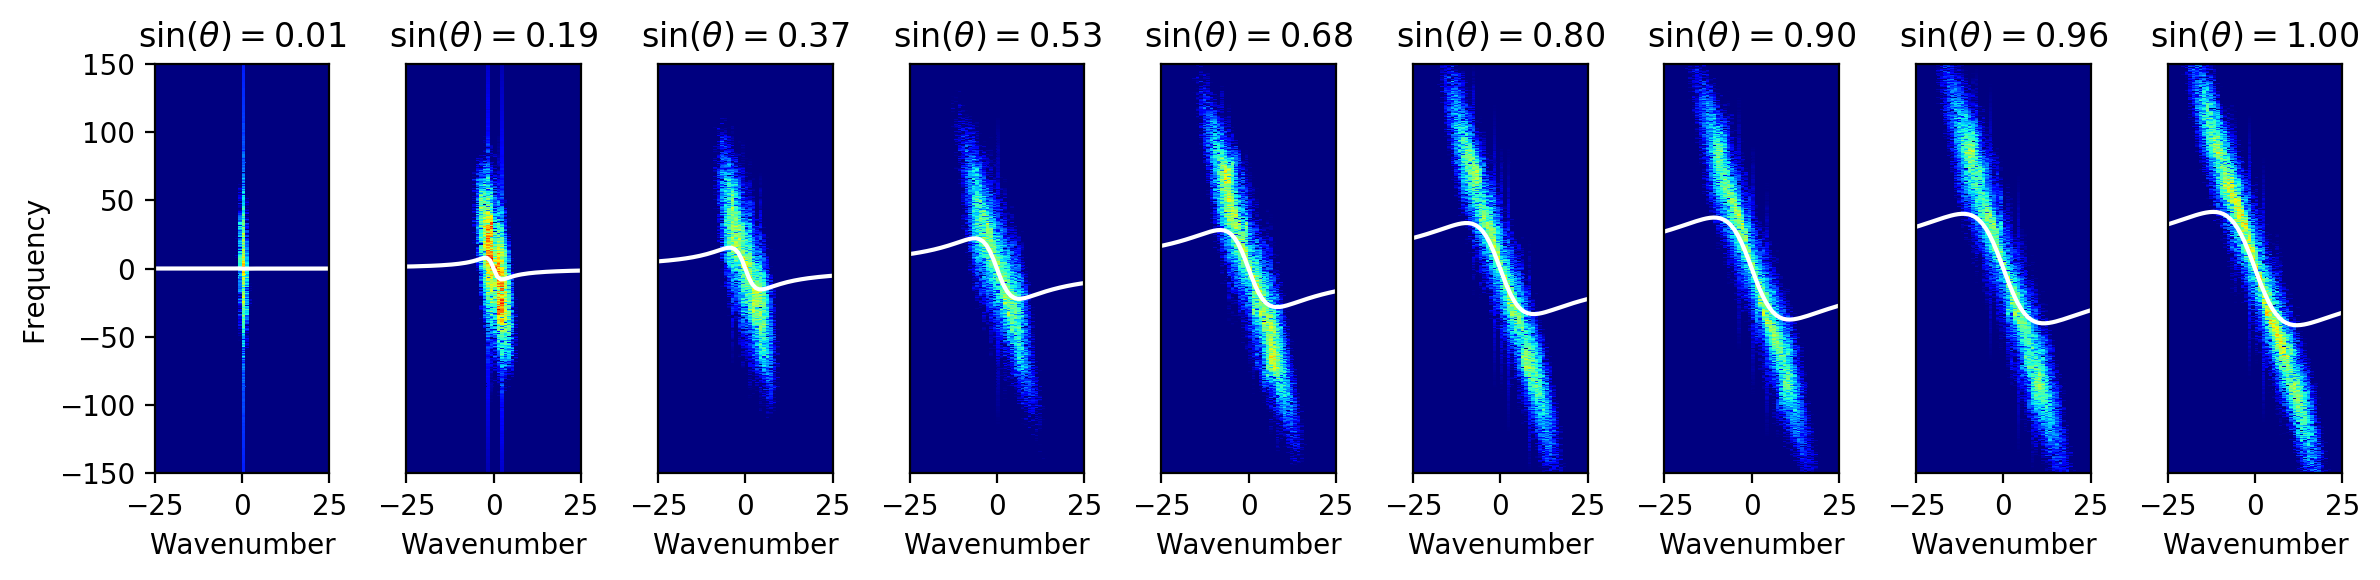

In [6]:
##### Plot FFT ######
plt.figure(figsize=(12, 3), dpi=200)

time_inds = np.arange(3000, 5000, 1)

#set the vertical wavenumber
ky = 12

count = 1
for i in th_inds:
    
    sig_eq = om[:, :, i]
    
    sig_fft = np.fft.fft2(sig_eq[time_inds, :])
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]

    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    #time freq is taken to be negative to be consistent with the waves definition
    time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi_freq, time_freq, np.log10(np.abs(sig_fft)), cmap='jet', vmin=4)
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Frequency')
    plt.title(r'$\sin(\theta) = %0.2f$' %(np.sin(theta[i])))
    plt.xlabel(r'Wavenumber')
    
    plt.plot(phi_freq, -2*Omega*phi_freq/((phi_freq**2/np.sin(theta[i])**2) + ky**2), 'w')
    
    plt.ylim([-150, 150])
    plt.xlim([-25, 25])

    count += 1

plt.tight_layout()
plt.savefig('../plots/%s_disp.png' %(STRNAME))


### Find the ridge

Slope is -7.03


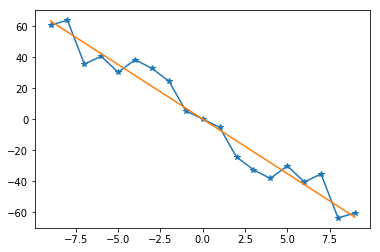

In [7]:
m_max = 10

#find the ridge 
th_ind = 100
sig_eq = om[:, :, th_ind]
sig_fft = np.fft.fft2(sig_eq[time_inds, :])
sig_fft = np.fft.fftshift(sig_fft)
dphi = phi[2] - phi[1]
dt = t_arr[2] - t_arr[1]
phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
mag = np.abs(sig_fft)
ridge = np.zeros(phi_freq.shape[0])

for i, m in enumerate(phi_freq):
    if np.abs(m)<m_max:
        max_ind = np.argmax(mag[:,i])
        ridge[i] = np.mean(time_freq[max_ind-10:max_ind+10])
    else:
        ridge[i] = np.nan
        
idx = np.isfinite(ridge)
p = np.polyfit(phi_freq[idx], ridge[idx], 1)
fit = np.poly1d(p)
        
plt.figure()
plt.plot(phi_freq, ridge, '*-')
plt.plot(phi_freq[idx], fit(phi_freq[idx]))

print('Slope is %0.2f' %(p[0]))


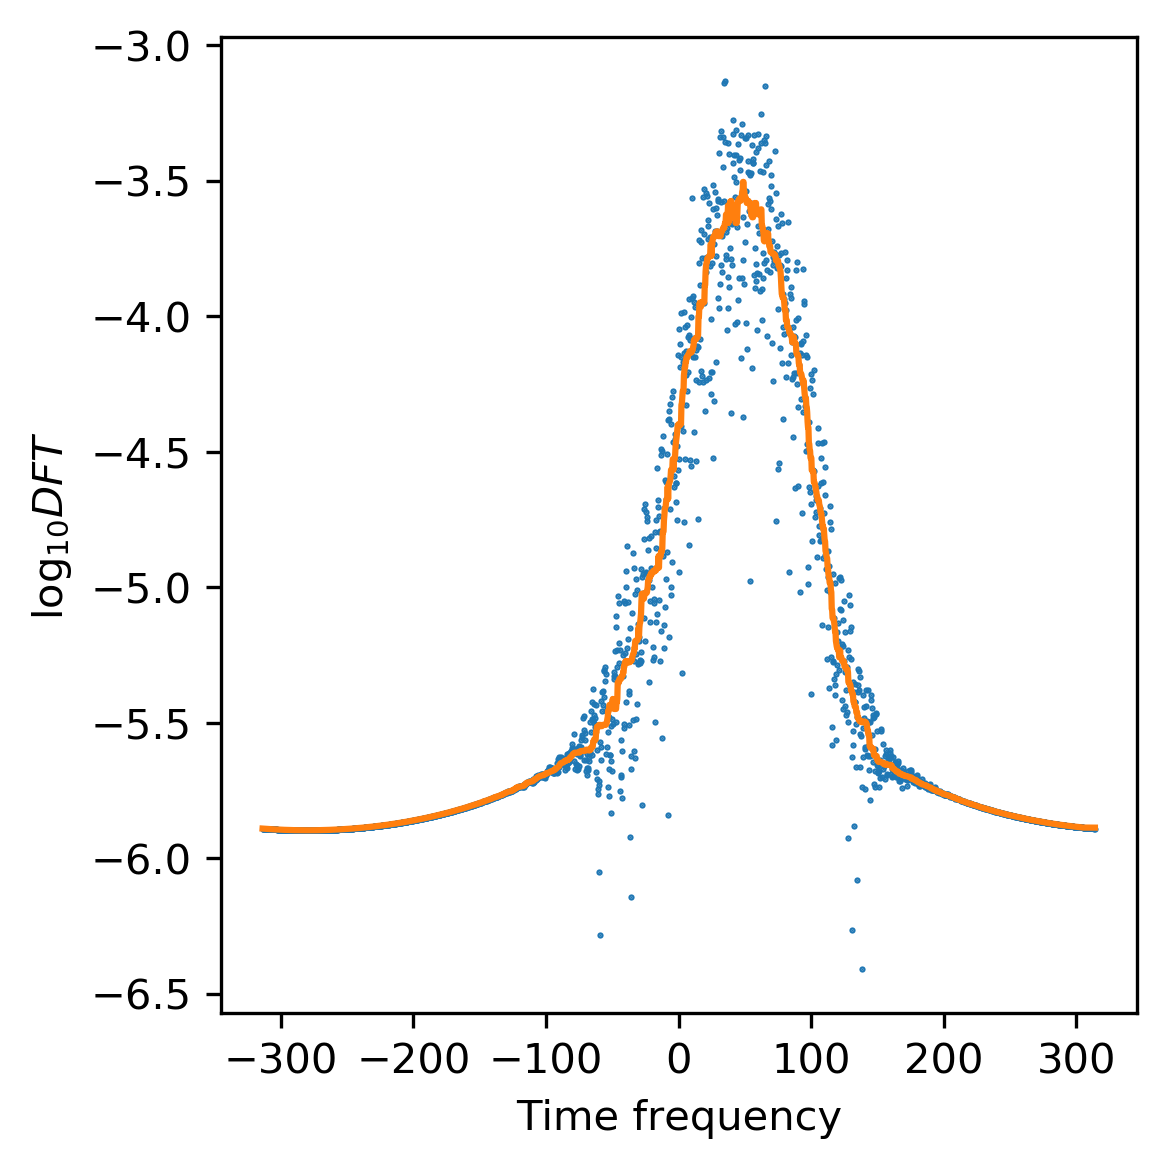

In [65]:
plt.figure(figsize=(4,4), dpi=300)

ind = 250
plt.plot(time_freq, np.log10(mag[:,250]), '.', markersize=1)
phi_freq[ind]

from scipy.optimize import curve_fit
from scipy.signal import find_peaks, find_peaks_cwt, medfilt

def gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

xdata = time_freq
ydata = np.log10(mag[:,250])
min_y = np.min(ydata)

popt, pcov = curve_fit(gauss, xdata, ydata-min_y, p0=[1, 40, 20])

maxinds = np.where(np.log10(mag[:,ind]) > np.max(np.log10(mag[:,ind]))-0.5)
ymean = np.mean(np.log10(mag[maxinds,ind]))
xmean = np.mean(time_freq[maxinds])

#plt.plot(xdata, gauss(xdata, popt[0], popt[1], popt[2]) + min_y)
#plt.plot(xmean, ymean, 'r*')

filtered = medfilt(ydata, 51)
plt.plot(xdata, filtered)
plt.xlabel('Time frequency')
plt.ylabel(r'$\log_{10} DFT$')

plt.tight_layout()

plt.savefig('../plots/filtering.pdf')

### Find the slope of the ridges at all angles

In [46]:
th_inds = np.arange(0,256, 5, dtype=int)
slope = np.zeros_like(th_inds, dtype=float)
error_slope = np.zeros_like(th_inds, dtype=float)
time_inds = np.arange(3000, 5000, 1)

for i in range(len(th_inds)):
    if i%10==0: print(i)

    sig_eq = om[:, :, th_inds[i]]
    sig_fft = np.fft.fft2(sig_eq[time_inds, :])
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]
    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    time_freq = -2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[time_inds]), d=dt))
    
    mag = np.abs(sig_fft)
    ridge = np.zeros(phi_freq.shape[0])
    ridge2 = np.zeros(phi_freq.shape[0])

    for j, m in enumerate(phi_freq):
        if np.abs(m)<m_max:
            #### method 1
            #maxinds = np.where(np.log10(mag[:,j]) > np.max(np.log10(mag[:,j]))-0.5)
            #xmean = np.mean(time_freq[maxinds])
            #ridge[j] = xmean
            
            #### method 2
            #delta_inds = 50
            #max_ind = np.argmax(mag[:,j])
            #ridge[j] = np.mean(time_freq[max_ind-delta_inds:max_ind+delta_inds])
            
            #### method 3 - median filter
            filtered = medfilt(np.log10(mag[:,j]), 51)
            max_ind = np.argmax(filtered)
            ridge[j] = time_freq[max_ind]
            
            filtered2 = medfilt(np.log10(mag[:,j]), 1)
            max_ind2 = np.argmax(filtered2)
            ridge2[j] = time_freq[max_ind2]
        
        else:
            ridge[j] = np.nan
            ridge2[j] = np.nan

    idx = np.isfinite(ridge)
    p = np.polyfit(phi_freq[idx], ridge[idx], 1)
    
    idx2 = np.isfinite(ridge2)
    p2 = np.polyfit(phi_freq[idx2], ridge2[idx2], 1)
    
    slope[i] = p[0]
    error_slope[i] = np.abs(p[0]-p2[0])
    


0
10
20
30
40
50


In [64]:
plt.figure(figsize=(6,3), dpi=300)
    
#plt.plot(theta[th_inds], slope*np.sin(theta[th_inds]), '*', markersize=2)  
plt.errorbar(theta[th_inds], slope*np.sin(theta[th_inds]), yerr=error_slope*np.sin(theta[th_inds]), fmt='o', \
            markersize=3, capsize=2)
l_p, l_m = get_l(4,1)
lmax0 = ((l_p+l_m)/2)

lmax_arr = np.arange(11, 15,1)
for lmax in lmax_arr:
    c0 = (-2*Omega/(lmax**2))*np.sin(theta[th_inds])
    plt.plot(theta[th_inds], c0, 'r--')

c00 = (-2*Omega/(lmax0**2))*np.sin(theta[th_inds])
plt.plot(theta[th_inds], c00, 'r-')
    
#plt.ylim([c00-2, c00+2])
plt.ylabel(r'$\left. \frac{\partial \sigma}{\partial k_x}  \right|_{k_x=0}$', usetex=True)
plt.xlabel(r'$\theta_0$', usetex=True)
plt.tight_layout()

plt.savefig('../plots/%s_slope.pdf' %(STRNAME))

ValueError: operands could not be broadcast together with shapes (52,) (9,) 

<Figure size 1200x1200 with 0 Axes>

In [38]:
error_slope

array([5.95717961, 5.95662845, 5.90702437, 5.84418   , 5.09513912,
       5.28143195, 5.3415213 , 5.12216006, 5.14805531, 5.43743212,
       4.79206787, 4.55673872, 4.38916955, 6.73755148, 6.92272478,
       6.83288385, 6.6543237 , 6.44983843, 7.07095987, 6.79707318,
       7.29200527, 8.00621648, 8.12802908, 8.02884182, 7.94399019,
       7.85580547, 7.78856224, 7.86240089, 8.16660086, 8.56782735,
       8.64555066, 8.1302442 , 8.20794996, 8.22943152, 8.45762409,
       8.64831159, 8.3413028 , 8.88254933, 8.68468112, 8.87261798,
       8.92166086, 8.80153129, 7.77697463, 7.23743183, 7.67283208,
       7.65407038, 7.97930265, 8.04432224, 8.39207555, 8.40529623,
       8.20467578, 8.20470823])

In [67]:
np.zeros(4)

array([0., 0., 0., 0.])

In [69]:
np.linsap

NameError: name 'floor' is not defined